In [ ]:
!pip install rasterio
!pip install geopandas
!pip install folium
!pip install keplergl

In [1]:
import os
from datetime import datetime

dir = "/kaggle/input/landsat-subset/test"

def string_to_date(date_string) -> datetime:
    '''
    Convert a string to a datetime object
    '''
    try:
        return datetime.strptime(date_string, "%Y%m%d")
    except ValueError as e:
        raise ValueError(f"Invalid date string format: {date_string}. Expected format is YYYYMMDD.") from e

def update_date_range(current_earliest, current_latest, new_date):
    '''
    Update the earliest and latest dates
    '''
    if current_earliest is None or new_date < current_earliest:
        current_earliest = new_date
    if current_latest is None or new_date > current_latest:
        current_latest = new_date
    return current_earliest, current_latest


tif_file_count = 0
mask_earliest_satellite_date = mask_latest_satellite_date = None
mask_earliest_process_date = mask_latest_process_date = None
rgb_earliest_satellite_date = rgb_latest_satellite_date = None
rgb_earliest_process_date = rgb_latest_process_date = None
conus_count = alaska_count = hawaii_count = 0
for file in os.listdir(dir):
    if not file.endswith(".TIF"):
        continue

    # Count total number of TIF files
    tif_file_count += 1
    
    # Count number of TIF files with CONUS, ALASKA, and HAWAII
    if "CU" in file:
        conus_count += 1
    elif "AK" in file:
        alaska_count += 1
    elif "HI" in file:
        hawaii_count += 1

    # Get earliest and latest date for mask and RGB
    satellite_date = string_to_date(file.split("_")[3])
    process_date = string_to_date(file.split("_")[4])
    if "B2" in file:
        rgb_earliest_satellite_date, rgb_latest_satellite_date = update_date_range(rgb_earliest_satellite_date, rgb_latest_satellite_date, satellite_date)
        rgb_earliest_process_date, rgb_latest_process_date = update_date_range(rgb_earliest_process_date, rgb_latest_process_date, process_date)
    elif "BC" in file:
        mask_earliest_satellite_date, mask_latest_satellite_date = update_date_range(mask_earliest_satellite_date, mask_latest_satellite_date, satellite_date)
        mask_earliest_process_date, mask_latest_process_date = update_date_range(mask_earliest_process_date, mask_latest_process_date, process_date)
    
print(f"Total number of TIF files: {tif_file_count}")
print(f"Number of CONUS TIF files: {conus_count}")
print(f"Number of ALASKA TIF files: {alaska_count}")
print(f"Number of HAWAII TIF files: {hawaii_count}")


print(f"Mask satellite date range: {mask_earliest_satellite_date:%Y-%m-%d} to {mask_latest_satellite_date:%Y-%m-%d}")
print(f"RGB satellite date range:  {rgb_earliest_satellite_date:%Y-%m-%d} to {rgb_latest_satellite_date:%Y-%m-%d}")

print(f"Mask process date range:   {mask_earliest_process_date:%Y-%m-%d} to {mask_latest_process_date:%Y-%m-%d}")
print(f"RGB process date range:    {rgb_earliest_process_date:%Y-%m-%d} to {rgb_latest_process_date:%Y-%m-%d}")


Total number of TIF files: 143
Number of CONUS TIF files: 143
Number of ALASKA TIF files: 0
Number of HAWAII TIF files: 0
Mask satellite date range: 2024-10-29 to 2024-11-05
RGB satellite date range:  2024-10-29 to 2024-11-05
Mask process date range:   2024-11-02 to 2024-11-09
RGB process date range:    2024-11-02 to 2024-11-09


## Extract Metadata

In [4]:
import rasterio
import os
import pandas as pd

metadata_list = []
dir = "/kaggle/input/landsat-subset/test"

for file in os.listdir(dir):
    if file.endswith(".TIF"):
        filepath = os.path.join(dir, file)
        with rasterio.open(filepath) as src:
            metadata = {
                "filename": file,
                "width": src.width,
                "height": src.height,
                "crs": src.crs,
                "bounds": src.bounds,
                "band_count": src.count,
                "dtype": src.dtypes[0]
            }
            metadata_list.append(metadata)

# Convert metadata to DataFrame for easier analysis
metadata_df = pd.DataFrame(metadata_list)
print(metadata_df.head())

                                            filename  width  height  \
0      LC09_CU_021017_20241030_20241103_02_SR_B4.TIF   5000    5000   
1      LC09_CU_028011_20241105_20241109_02_SR_B3.TIF   5000    5000   
2  LC09_CU_026018_20241103_20241107_02_SR_QA_AERO...   5000    5000   
3  LC09_CU_029005_20241031_20241104_02_QA_LINEAGE...   5000    5000   
4      LC09_CU_026017_20241103_20241107_02_SR_B3.TIF   5000    5000   

                                                 crs  \
0  (proj, lat_0, lon_0, lat_1, lat_2, x_0, y_0, d...   
1  (proj, lat_0, lon_0, lat_1, lat_2, x_0, y_0, d...   
2  (proj, lat_0, lon_0, lat_1, lat_2, x_0, y_0, d...   
3  (proj, lat_0, lon_0, lat_1, lat_2, x_0, y_0, d...   
4  (proj, lat_0, lon_0, lat_1, lat_2, x_0, y_0, d...   

                                         bounds  band_count   dtype  
0      (584415.0, 614805.0, 734415.0, 764805.0)           1  uint16  
1  (1634415.0, 1514805.0, 1784415.0, 1664805.0)           1  uint16  
2    (1334415.0, 464805.0,

## Mask Analysis

Mask Class Distribution: {0: 3702716, 1: 374, 251: 125230, 253: 1963485, 254: 1165152, 255: 18043043}


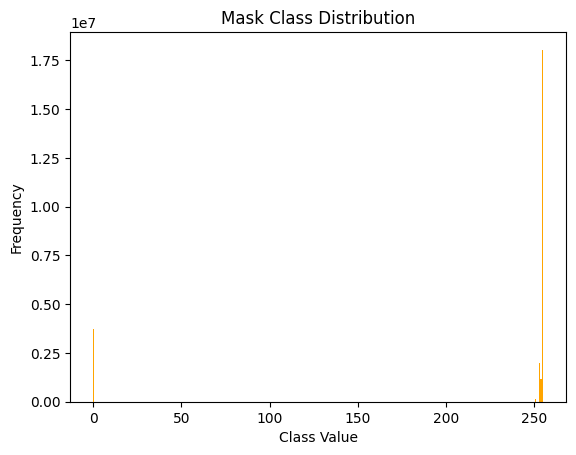

In [15]:
mask_files = [file for file in os.listdir(dir) if "BC" in file]

# Example: Analyze mask pixel values for the first file
with rasterio.open(os.path.join(dir, mask_files[0])) as src:
    mask_data = src.read(1)

# Check unique values (e.g., classes) and their proportions
unique, counts = np.unique(mask_data, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Mask Class Distribution:", class_distribution)

# Plot class distribution
plt.bar(class_distribution.keys(), class_distribution.values(), color="orange")
plt.title("Mask Class Distribution")
plt.xlabel("Class Value")
plt.ylabel("Frequency")
plt.show()

## Visualizing the Mask

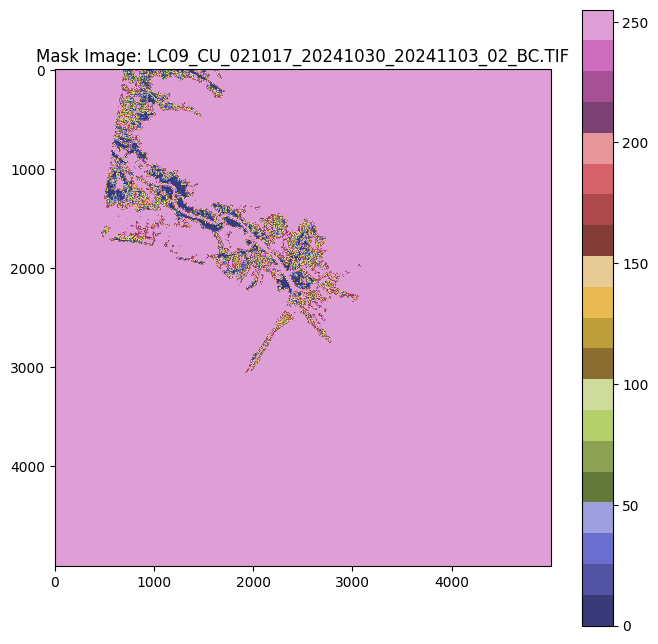

In [33]:
import matplotlib.pyplot as plt
import rasterio
    
mask_file = mask_files[10]  # Select a mask file
with rasterio.open(os.path.join(dir, mask_file)) as src:
    mask_image = src.read(1)

plt.figure(figsize=(8, 8))
plt.imshow(mask_image, cmap="tab20b")  # Use a color map for classes
plt.colorbar()
plt.title(f"Mask Image: {mask_file}")
plt.show()


## Load Metadata and Display Information

CRS: PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Transform: | 30.00, 0.00,-465585.00|
| 0.00,-30.00, 1064805.00|
| 0.00, 0.00, 1.00|
Width, Height: 5000 5000
Number of Bands: 1
Metadata: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 5000, 'height': 5000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]]

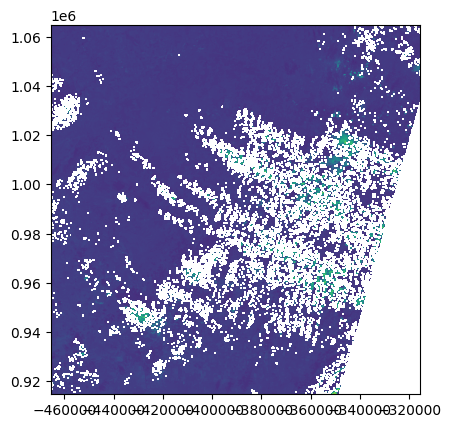

In [35]:
import rasterio
from rasterio.plot import show

# Load a sample TIF file
file_path = "/kaggle/input/landsat-subset/test/LC08_CU_014015_20241030_20241108_02_SR_B1.TIF"

with rasterio.open(file_path) as src:
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Width, Height:", src.width, src.height)
    print("Number of Bands:", src.count)
    print("Metadata:", src.meta)
    show(src)  # Visualize the first band


## Statistics for Each Band

In [36]:
import numpy as np

with rasterio.open(file_path) as src:
    for i in range(1, src.count + 1):
        band = src.read(i)
        print(f"Band {i}: Mean={np.mean(band):.2f}, StdDev={np.std(band):.2f}")

Band 1: Mean=8923.82, StdDev=4821.76


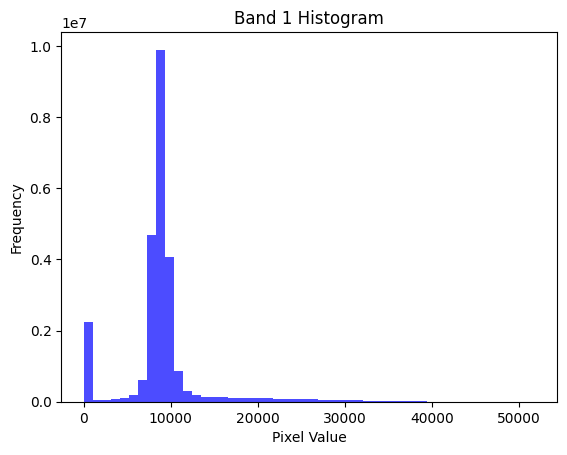

In [38]:
with rasterio.open(file_path) as src:
    band = src.read(1)  # Example for the first band
    plt.hist(band.ravel(), bins=50, color="blue", alpha=0.7)
    plt.title("Band 1 Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()


## Overlay Masks

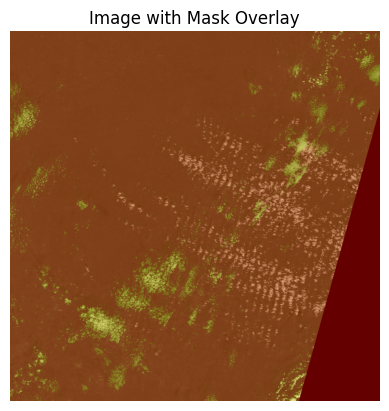

In [40]:
mask_path = "/kaggle/input/landsat-subset/test/LC08_CU_014015_20241030_20241108_02_QA_PIXEL.TIF"

with rasterio.open(file_path) as img_src, rasterio.open(mask_path) as mask_src:
    img = img_src.read(1)
    mask = mask_src.read(1)
    
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, cmap="autumn", alpha=0.4)  # Overlay mask
    plt.title("Image with Mask Overlay")
    plt.axis("off")
    plt.show()


## Class Distribution

In [45]:
import pandas as pd

with rasterio.open(mask_path) as mask_src:
    mask = mask_src.read(1)
    unique, counts = np.unique(mask, return_counts=True)
    class_distribution = pd.DataFrame({'Class': unique, 'Count': counts})
    print(class_distribution)


    Class     Count
0       1   2167347
1   21762    521000
2   21824  14050513
3   21890      4432
4   21952     46689
5   22018    129402
6   22080     45874
7   22146       232
8   22208        33
9   22280   3029123
10  23826    888776
11  23888   2547327
12  24082    250464
13  24144     51604
14  29986         4
15  30048         1
16  54534     73789
17  54596     53495
18  54662         7
19  54790     24017
20  54852      5033
21  55052    975410
22  56598     97562
23  56660     16817
24  56854     17994
25  56916      3055


## Check Alignment

In [46]:
with rasterio.open(file_path) as img_src, rasterio.open(mask_path) as mask_src:
    print("Image CRS:", img_src.crs)
    print("Mask CRS:", mask_src.crs)
    print("Aligned:", img_src.transform == mask_src.transform)


Image CRS: PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Mask CRS: PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_pa

## K-means Clustering

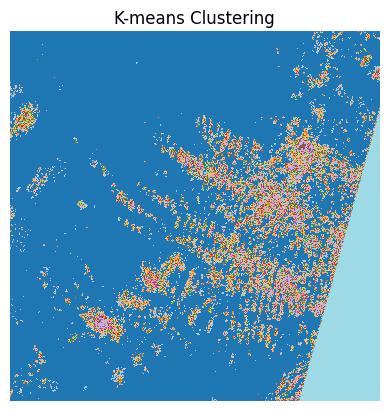

In [50]:
from sklearn.cluster import KMeans

with rasterio.open(file_path) as src:
    band = src.read(1)
    flat_band = band.reshape(-1, 1)
    kmeans = KMeans(n_clusters=3).fit(flat_band)
    clustered = kmeans.labels_.reshape(band.shape)
    
plt.imshow(clustered, cmap="tab20")
plt.title("K-means Clustering")
plt.axis("off")
plt.show()
